In [1]:
import os
import random
import numpy as np
import pandas as pd

user_clip_num = 2
user_pos_num_clip = 2 # only split users with training positive interactions >= user_clip_num * user_pos_num_clip
max_interact_num = 10
like_threshold = 3


data_path = '../coat-origin/'
feature_path = '../coat-origin/user_item_features/'

train_matrix = np.loadtxt(data_path + "train.ascii")
test_matrix = np.loadtxt(data_path + "test.ascii")
print(train_matrix.shape, test_matrix.shape)

(290, 300) (290, 300)


In [2]:
path='./features'
if not os.path.exists(path):
    os.mkdir(path)
path='./sets'
if not os.path.exists(path):
    os.mkdir(path)

In [3]:
train_list = []
train_dict = {}
for u in range(train_matrix.shape[0]):
    if u not in train_dict:
        train_dict[u] = []
    for i in range(train_matrix.shape[1]):
        if train_matrix[u][i]>3:
            train_dict[u].append(i)
            train_list.append([u,i])

print('len train_list:', len(train_list))
print('len train_dict', len(train_dict))

len train_list: 1905
len train_dict 290


In [4]:
test_list0 = []
test_dict0 = {}
for u in range(test_matrix.shape[0]):
    if u not in test_dict0:
        test_dict0[u] = []
    for i in range(test_matrix.shape[1]):
        if test_matrix[u][i]>3:
            test_dict0[u].append(i)
            test_list0.append([u,i])

print('len test_list0:', len(test_list0))
print('len test_dict0', len(test_dict0))

len test_list0: 860
len test_dict0 290


In [5]:
valid_dict = {}
test_dict = {}
test_list = []
for u in test_dict0:
    items = test_dict0[u]
    if (len(items) > 2):
        valid_dict[u] = items[:-int(len(items)/2)] 
        test_dict[u] = items[-int(len(items)/2):]
        test_list += [[u,i] for i in test_dict[u]]
    else:
        continue
print('len test_dict:', len(test_dict))
print('len test_list:', len(test_list))


len test_dict: 131
len test_list: 311


In [6]:
# added for splitting users: only split training data, keep testing data untouched.
user_all_dict = {} # to record every exposure interaction with time and watch_ratio
for u in range(train_matrix.shape[0]):
    for i in range(train_matrix.shape[1]):
        if train_matrix[u][i]>3:
        # this is a recorded positive interaction
            if u not in user_all_dict:
                user_all_dict[u] = {'exposure':[], 'like':[]}
            user_all_dict[u]['exposure'].append([i, train_matrix[u][i]])
            user_all_dict[u]['like'].append([i, train_matrix[u][i]])
        elif train_matrix[u][i]!=0:                
            if u not in user_all_dict:
                user_all_dict[u] = {'exposure':[], 'like':[]}
            user_all_dict[u]['exposure'].append([i, train_matrix[u][i]])


In [7]:
item_features_matrix = np.loadtxt(feature_path + "item_features.ascii")
item_type_matrix = item_features_matrix[:,2:18] # jacket type features
item_feature_dict_ori = {}
for i in range(item_type_matrix.shape[0]):
    for c in range(item_type_matrix.shape[1]):
        if item_type_matrix[i][c] == 1:
            item_feature_dict_ori[i] = [c]

category_list_ori = list(range(item_type_matrix.shape[1]))

# np.save('./features/item_feature_dict.npy', np.array(item_feature_dict))
# np.save('./features/category_list.npy', np.array(category_list))

In [8]:
embed_item = np.load("./embed_item_FM_coat_0.0875.npy")
# for i in range(embed_item.shape[0]):
#     embed_item[i] /= np.linalg.norm(embed_item[i])
print(embed_item.shape)

(300, 256)


In [9]:
category_map_dict = {}
cate_embed = np.zeros([len(category_list_ori), embed_item.shape[1]])
category_count_dict = {}
for i in range(embed_item.shape[0]):
    for c in item_feature_dict_ori[i]:
        if c not in category_count_dict:
            category_count_dict[c] = 1/len(item_feature_dict_ori[i])
        else:
            category_count_dict[c] += 1/len(item_feature_dict_ori[i])
        cate_embed[c] += embed_item[i]

for c in category_count_dict:
    cate_embed[c] /= category_count_dict[c]

for i in range(cate_embed.shape[0]):
    cate_embed[i] /= np.linalg.norm(cate_embed[i])

In [10]:
import pandas as pd  
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  
from tqdm import tqdm
'利用SSE选择k'  
SSE = []  # 存放每次结果的误差平方和  
for k in tqdm(range(1,17)):  
    estimator = KMeans(n_clusters=k, random_state=1)  # 构造聚类器  
    estimator.fit(cate_embed)  
    SSE.append(estimator.inertia_) 

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
  6%|█████▏                                                                             | 1/16 [00:00<00:06,  2.27it/s]D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 12%|██████████▍                                                                        | 2/16 [00:00<00:05,  2.77it/s]D:\download\anaconda\envs\myjupyter\lib\site-

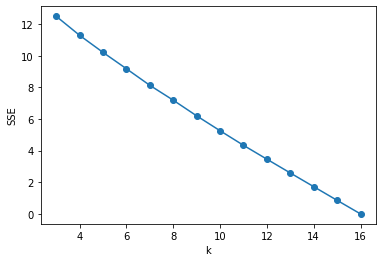

In [11]:
X = range(1,17) 
plt.xlabel('k')  
plt.ylabel('SSE')  
plt.plot(X[2:],SSE[2:],'o-')  
plt.show() 

In [12]:
from sklearn.cluster import KMeans
category_num_new = 3
kmeans_model = KMeans(category_num_new, random_state=1)
kmeans_model.fit(cate_embed)
labels = kmeans_model.labels_
print(kmeans_model.labels_)
print(kmeans_model.inertia_)

D:\download\anaconda\envs\myjupyter\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 0 0 2 1 0 1 1 0 0 1 1 1 2 1 2]
12.493225301275036


In [13]:
for i in set(labels):
    print(i, sum(labels==i))

0 6
1 7
2 3


In [14]:
# create item_feature_dict file CHANGED!!!
item_feature_dict = {}
for item in range(len(item_feature_dict_ori)):
    item_feature_dict[item]=[]
    for i in range(len(item_feature_dict_ori[item])):
        if labels[item_feature_dict_ori[item][i]] not in item_feature_dict[item]:
            item_feature_dict[item].append(labels[item_feature_dict_ori[item][i]])

np.save('./features/item_feature_dict.npy', np.array(item_feature_dict))

# create category_list file
category_list = list(range(category_num_new))
np.save('./features/category_list.npy', np.array(category_list))

In [15]:
# split users and generate new big_pos_dict and big_pos_list.
big_pos_dict = dict(train_dict)
big_pos_list = list(train_list)
# a function to calc T given exposure items and item_category_dict&category_list
def calc_T(t_seq, item_category, category_list):
    cate_dis = [0] * (max(category_list)+1)
    for item in t_seq:
        for c in item_category[item]:
            cate_dis[c] += 1/len(item_category[item])
    cate_dis = [c/len(t_seq) for c in cate_dis]
    return cate_dis

# a function to calc Y given exposure items, liked items, and item_category_dict&category_list
def calc_Y(t_seq, next_d, item_category, category_list):
    exposure_dis = [0]* (max(category_list)+1)
    like_dis = [0]* (max(category_list)+1)
    for item in t_seq:
        for c in item_category[item]:
            exposure_dis[c] += 1/len(item_category[item])
    for item in next_d:
        for c in item_category[item]:
            like_dis[c] += 1/len(item_category[item])
    ctr_dis = [like_dis[c]/exposure_dis[c] if exposure_dis[c] > 0 else 0 for c in range(len(exposure_dis))]
    return ctr_dis
    
subuser_all_dict = {} # subuserID
user_subuser_map = {}
user_subuser_exp_dict = {} # save exposure data of users and subusers
user_num = max(big_pos_dict.keys())+1 # len(user_id_map)
assert user_num not in big_pos_dict

for uID in (user_all_dict):
    pos_num = len(user_all_dict[uID]['like'])
    
    # save exposure data of uID
    user_subuser_exp_dict[uID] = [entry[0] for entry in user_all_dict[uID]['exposure']]
    
    # only split users with postive len > user_clip_num * user_pos_num_clip
    if pos_num < user_clip_num * user_pos_num_clip:
        continue
    pos_num_clip = pos_num//user_clip_num
    for i in range(user_clip_num-1):
        
        subuser_id = user_num
        user_num += 1
        user_subuser_map[subuser_id] = uID
        subuser_all_dict[subuser_id] = {}
        
        # find like history in current clip
        d = user_all_dict[uID]['like'][:(i+1)*pos_num_clip]
        
        # find treatment in next clip
        st = user_all_dict[uID]['exposure'].index(user_all_dict[uID]['like'][(i+1)*pos_num_clip])
        if i != user_clip_num-2: # not last clip
            ed = user_all_dict[uID]['exposure'].index(user_all_dict[uID]['like'][(i+2)*pos_num_clip])
            t_seq = user_all_dict[uID]['exposure'][st:ed]
        else:
            t_seq = user_all_dict[uID]['exposure'][st:]
            
        # find like history in next clip
        if i != user_clip_num-2: # not last clip
            next_d = user_all_dict[uID]['like'][(i+1)*pos_num_clip:(i+2)*pos_num_clip]
        else:
            next_d = user_all_dict[uID]['like'][(i+1)*pos_num_clip:]
        
        # save exposure data of subuser_id: find the last liked item and save its exposure.
        exposure_index = user_all_dict[uID]['exposure'].index(d[-1])
        user_subuser_exp_dict[subuser_id] = user_all_dict[uID]['exposure'][:exposure_index+1]
        
        d = [entry[0] for entry in d]
        next_d = [entry[0] for entry in next_d]
        t_seq = [entry[0] for entry in t_seq]
        
        T = calc_T(t_seq, item_feature_dict, category_list)
        Y = calc_Y(t_seq, next_d, item_feature_dict, category_list)

        subuser_all_dict[subuser_id]['D'] = d
        subuser_all_dict[subuser_id]['T'] = T
        subuser_all_dict[subuser_id]['Y'] = Y
                
        # update big_pos_dict and big_pos_list
        for item in d:
            if subuser_id not in big_pos_dict:
                big_pos_dict[subuser_id] = []
            big_pos_dict[subuser_id].append(item)
            big_pos_list.append([subuser_id, item])

        if uID == 0:
            print(subuser_all_dict[subuser_id])
        

{'D': [227, 228, 235, 236, 247], 'T': [0.36363636363636365, 0.2727272727272727, 0.36363636363636365], 'Y': [0.25, 0.6666666666666666, 0.5]}


In [16]:
np.save('./sets/training_list.npy', np.array(big_pos_list))
np.save('./sets/training_dict.npy', np.array(big_pos_dict))
np.save('./sets/validation_dict.npy', np.array(valid_dict))
np.save('./sets/testing_dict.npy', np.array(test_dict))

np.save('./features/user_subuser_exp_dict.npy', np.array(user_subuser_exp_dict))
np.save('./features/user_subuser_map.npy', np.array(user_subuser_map))
np.save('./features/subuser_info.npy', np.array(subuser_all_dict))

In [17]:
pop_rank = dict(pd.DataFrame(train_list)[1].value_counts())
print(len(pop_rank))
for i in range(train_matrix.shape[1]):
    if i not in pop_rank:
        pop_rank[i] = 0
print(len(pop_rank))

item_rank_dict = {} #id:rank
rank = 0
for element in pop_rank:
    item_rank_dict[element] = rank
    rank += 1
np.save('./features/item_rank_dict.npy', np.array(item_rank_dict))

284
300


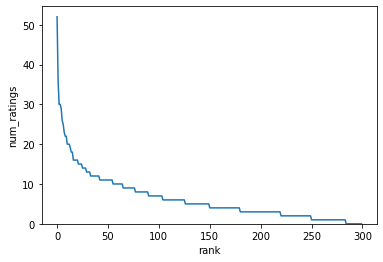

In [18]:
import matplotlib.pyplot as plt
a = pop_rank.values()
plt.plot(a)
plt.ylim(bottom=0.)
#ax.set_xlim(left=0.)
plt.xlabel("rank")
plt.ylabel("num_ratings")
plt.show()

In [19]:
category_num = len(category_list)
topk_category = 3
user_fml_cat_big = {}
for user in train_dict:
    category_cnt = [0] * category_num
    for item in train_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_big[user] = fml_cat
np.save('./features/user_fml_cat.npy', np.array(user_fml_cat_big))

In [21]:
user_feature_file = {}
for userID in big_pos_dict:
    user_feature_file[userID] = [['U'+str(userID)]]
    user_feature_file[userID].append([str(1)]*len(user_feature_file[userID][0]))

item_feature_file = {}
for itemID in item_feature_dict:
    item_feature_file[itemID] = [['I'+str(itemID)]]
    item_feature_file[itemID].append(['1'])
    for cate in range(0, len(category_list)):
        if cate in item_feature_dict[itemID]:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(round(1.0/len(item_feature_dict[itemID]), 2)))
        else:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(0))
np.save('./features/user_feature_file.npy', np.array(user_feature_file))
np.save('./features/item_feature_file.npy', np.array(item_feature_file))

In [22]:
item_cat_vec = {}
for itemID in item_feature_dict:
    item_cat_vec[itemID] = [0] * category_num
    cat_num = len(item_feature_dict[itemID])
    for cat in item_feature_dict[itemID]:
        item_cat_vec[itemID][cat] = 1 / np.sqrt(cat_num)
np.save('./features/item_cat_vec.npy', np.array(item_cat_vec))

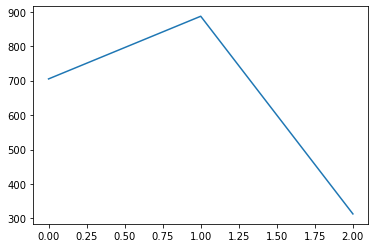

[705, 887, 313]


In [23]:
CountAll = [0] * len(category_list)
for item in pop_rank:
    CountAll[item_feature_dict[item][0]]+=pop_rank[item]
plt.plot(CountAll)
plt.show()
print(CountAll)